In [1]:
'''
Program to perform 3D element analysis
Unit: mm
Author: Yitian Shao
Created on 2021.06.02
'''
%matplotlib notebook 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

meshDensity = 100 # density of vertices of the mesh, large value results in finer grid but larger memory demand
adPlotDensity = 50 # density of additive plot of curves and circles

In [2]:
'''
Simulation parameters 
'''
R = 50 # (mm) Radius of the sphere
f = 34.641 # (mm) Offset distance of the front cut from the center of the sphere
m = 20 # (mm) half-length of the open area of the pouch, m < r

r = np.sqrt(R**2 - f**2) # Radius of the front cutting circle, r < R
h = np.sqrt(r**2 - m**2) # (mm) Cutting height of the sphere, Pouch height will be 2(r-h)
alpha = np.arccos(h/r) # Angle viewing from the front
s = np.sqrt(m**2 + f**2) # Radius of the top cutting circle
beta = np.arctan(m/(f + s)) # Angle viewing from the top
n = s * np.cos(beta)
rSide = np.sqrt(n**2 + h**2)

print("r = %.2f mm, h = %.2f mm, s = %.2f mm, n = %.2f mm, rSide = %.2f mm" % (r, h, s, n, rSide))
print("Angle: Alpha = %.1f degree, Beta = %.1f degree" % (180*alpha/np.pi, 180*beta/np.pi))

# Side circle coordinates
triangleTopX = R - s
cCenterX = n * np.cos(beta) + triangleTopX
cCenterY = -n * np.sin(beta)
triangleBottomX = 2 * n * np.cos(beta) + triangleTopX

r = 36.06 mm, h = 30.00 mm, s = 40.00 mm, n = 38.64 mm, rSide = 48.92 mm
Angle: Alpha = 33.7 degree, Beta = 15.0 degree


In [3]:
'''
Functions
'''
def data_cut(x, y, z, ind):
    return x[ind], y[ind], z[ind]

def coordTrans2D(a, b, theta, a_translate, b_translate):
    # 2D coordinate transformation, rotate counter-clockwise by angle theta and then translate
    rotMat = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    ab = np.matmul(rotMat, np.stack((a, b)))
    ab[0,:] += a_translate
    ab[1,:] += b_translate
    return ab

def fitPlane2Points(p1, p2, p3):
    # Fit a plane to three nonalighed points
    return np.cross(p1 - p2, p3 - p2)

In [4]:
x = np.outer(np.linspace(0, 2*R, meshDensity), np.ones(meshDensity))
y = np.outer(np.linspace(-R, R, meshDensity), np.ones(meshDensity)).T
z = R**2 - (x-R)**2 - (y**2)

# Keep sphere surface
keepInd = (z >= 0)
x, y, z = data_cut(x, y, z, keepInd)
z = np.sqrt(z)

# Cut the sphere
keepInd = (z >= h)
x, y, z = data_cut(x, y, z, keepInd)

# Cut the Front Face (surface crossing the pouch)
keepInd = (x <= f + R)
x, y, z = data_cut(x, y, z, keepInd)

# Cut the left-side face
pNormVector = fitPlane2Points(np.array([triangleTopX, 0, h]), np.array([cCenterX, cCenterY, 0]), 
                              np.array([triangleBottomX, -m, h]))
keepInd = (np.matmul(pNormVector, np.stack((x, y, z))) >= 0)
x, y, z = data_cut(x, y, z, keepInd)

# Cut the right-side face
pNormVector2 = fitPlane2Points(np.array([triangleTopX, 0, h]), np.array([cCenterX, -cCenterY, 0]), 
                              np.array([triangleBottomX, m, h]))
keepInd = (np.matmul(pNormVector2, np.stack((x, y, z))) <= 0)
x, y, z = data_cut(x, y, z, keepInd)

<IPython.core.display.Javascript object>


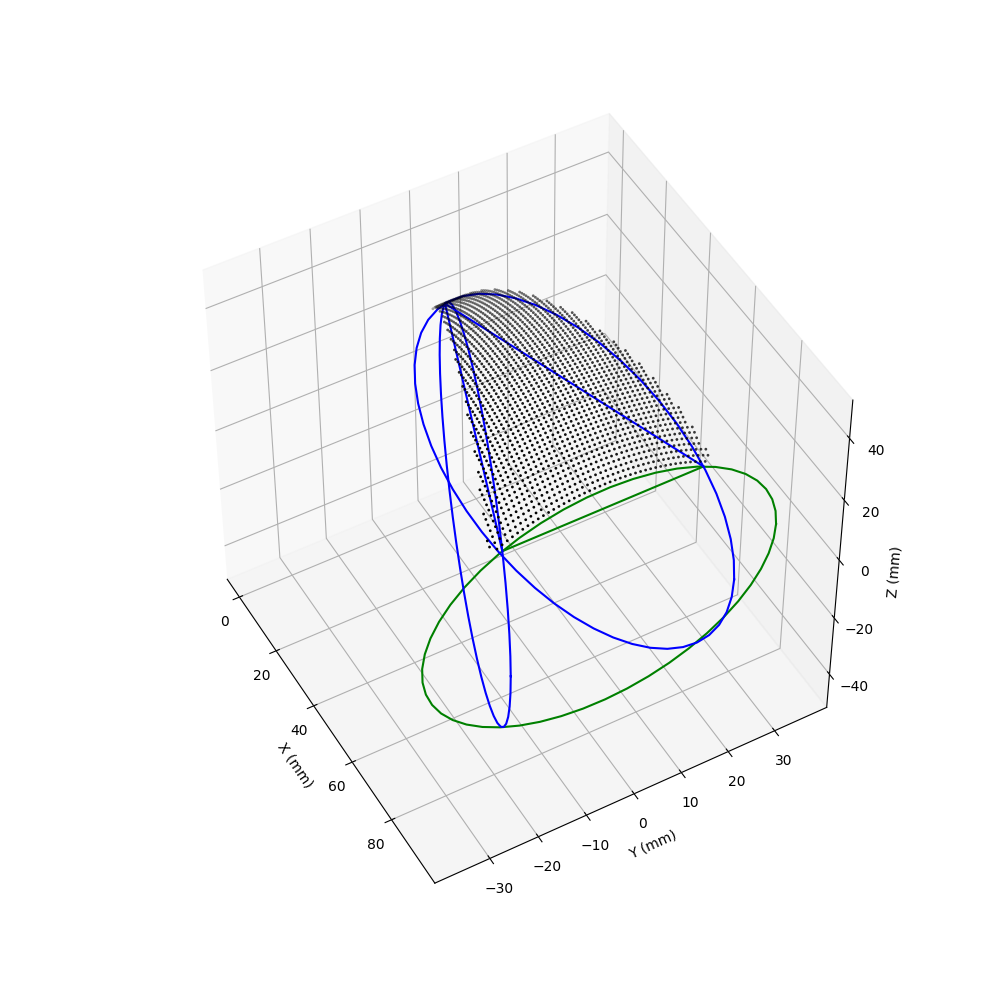

In [5]:
fig1 = plt.figure(figsize = (10,10))
ax = fig1.add_subplot(111, projection='3d')
ax.scatter3D(x, y, z, s = 1, edgecolor="k", facecolor="none")
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_zlim3d([-R, R])
ax.set_box_aspect([1.0, 1.0, 1.0])

In [6]:
# Additive plot
# Plot front circle
fAngle = np.linspace(0, 2*np.pi, adPlotDensity)
x = (R + f) * np.ones(adPlotDensity)
y = r * np.cos(fAngle)
z = r * np.sin(fAngle)
ax.plot(x, y, z, c = 'g')
# Plot front line
ax.plot([R + f, R + f], [-m, m], [h, h], c = 'g')

x, y = coordTrans2D(rSide * np.cos(fAngle), np.zeros(adPlotDensity), -beta, cCenterX, cCenterY)
z = rSide * np.sin(fAngle)
ax.plot(x, y, z, c = 'b')
x, y = coordTrans2D(rSide * np.cos(fAngle), np.zeros(adPlotDensity), beta, cCenterX, -cCenterY)
ax.plot(x, y, z, c = 'b')
# Plot side line
ax.plot([triangleTopX, triangleBottomX], [0, -m], [h, h], c = 'b')
ax.plot([triangleTopX, triangleBottomX], [0, m], [h, h], c = 'b')

In [7]:
plt.show()

In [8]:
print(x.shape, y.shape, z.shape)

(50,) (50,) (50,)
